# Load data

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as K

In [2]:
def read_data(name):
    X_train, y_train = [], []
    X_test, y_test = [], []
    X = np.load(f'data/keypoints/{name}.npy') # .reshape((-1, 51))
    with open(f'data/labels/{name}') as f:
        labels = f.readlines()

    N = int(re.findall(r'\d+', labels[0])[0])
    assert N == X.shape[0]

    end = 0

    for lab in labels:
        C = re.findall(r'\d:', lab)
        if len(C) == 1:
            C = int(C[0][0])

        idxs = re.findall(r'\d+-\d+', lab)
        if len(idxs) > 1:  
            print()
            print(f'Add label [{C}] to train samples')
            for idx in idxs[:-1]:
                start, stop = idx.split('-')
                start, stop = int(start), int(stop)

                X_train.append(X[end:start])
                y_train.append(0)

                X_train.append(X[start:stop])
                y_train.append(C)        
                print(idx, end='\t')

                end = stop
            
            print()
            print(f'Add label [{C}] to test samples')
            idx = idxs[-1]
            start, stop = idx.split('-')
            start, stop = int(start), int(stop)

            X_test.append(X[end:start])
            y_test.append(0)
            
            print(idx, end='\t')
            X_test.append(X[start:stop])
            y_test.append(C)        

            end = stop

    X_train.append(X[end:-1])
    y_train.append(0)
    
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = [], [], [], []

FILE_NAMES = ['id0_jab_1',  'id0_jab_2', 
              'id0_hook_1', 'id0_hook_2',
              'id0_uper_1', 'id0_uper_2']

for name in FILE_NAMES:
    x1, y1, x2, y2 = read_data(name)

    X_train += x1
    y_train += y1
    X_test += x2
    y_test += y2


Add label [1] to train samples
5-30	42-70	88-115	130-154	
Add label [1] to test samples
170-200	
Add label [2] to train samples
220-247	268-293	315-340	365-387	
Add label [2] to test samples
417-436	
Add label [1] to train samples
465-493	515-538	560-583	605-625	
Add label [1] to test samples
650-675	
Add label [2] to train samples
696-715	742-762	787-807	833-850	
Add label [2] to test samples
878-895	
Add label [1] to train samples
19-39	68-89	107-147	156-190	
Add label [1] to test samples
215-243	
Add label [2] to train samples
266-288	317-334	361-382	413-433	
Add label [2] to test samples
462-482	
Add label [1] to train samples
564-578	600-615	639-657	680-695	
Add label [1] to test samples
720-737	
Add label [2] to train samples
764-778	802-817	840-857	884-898	
Add label [2] to test samples
924-939	
Add label [3] to train samples
1-22	45-70	92-117	141-164	
Add label [3] to test samples
202-225	
Add label [4] to train samples
275-300	319-344	372-395	430-455	
Add label [4] to test sa

In [4]:
len(X_train), len(X_test)

(200, 48)

In [5]:
for i in range(len(X_train)):
    N = X_train[i].shape[0]
    x = X_train[i].reshape((N, 17, 3))
    mid_points = (x[:, 11, :] + x[:, 12, :]) / 2
    mp = mid_points.reshape(N, 1, 3)
    x_n = x - mp
    X_train[i] = np.concatenate([x_n, mp], axis=1).reshape(-1, 54)

In [6]:
for i in range(len(X_test)):
    N = X_test[i].shape[0]
    x = X_test[i].reshape((N, 17, 3))
    mid_points = (x[:, 11, :] + x[:, 12, :]) / 2
    mp = mid_points.reshape(N, 1, 3)
    x_n = x - mp
    X_test[i] = np.concatenate([x_n, mp], axis=1).reshape(-1, 54)

In [7]:
X_train[-1].shape

(52, 54)

In [8]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.ragged.constant(X_train)

y_test = K.utils.to_categorical(y_test, num_classes=7)
X_test = tf.ragged.constant(X_test)

2021-10-29 22:00:48.524015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
X_train.shape

TensorShape([200, None, None])

## LSTM

In [10]:
def build_model(reccur_features=32, dense_features=64):
    inpu = K.layers.InputLayer((None, 54))
    rnn = K.layers.LSTM(reccur_features)
    dense1 = K.layers.Dense(dense_features, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-1))
    dense2 = K.layers.Dense(7, activation='softmax')

    model = K.Sequential([inpu, rnn, dense1, dense2])
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [11]:
import random
results = {}

In [12]:
RF = [n for n in range(8, 64)]
DF = [n for n in range(8, 64)]

for i in range(8):
    rf = random.choice(RF)
    df = random.choice(DF)
    model = build_model(rf, df)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=4, epochs=16)
    results[(rf, df)] = history.history['val_accuracy'][-1]

Epoch 1/16


2021-10-29 22:00:49.754065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-29 22:00:49.788808: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3912000000 Hz


50/50 [==============================] - 2s 14ms/step - loss: 3.0885 - accuracy: 0.4850 - val_loss: 2.6866 - val_accuracy: 0.5000
Epoch 2/16
50/50 [==============================] - 0s 9ms/step - loss: 2.2748 - accuracy: 0.5600 - val_loss: 1.8691 - val_accuracy: 0.6250
Epoch 3/16
50/50 [==============================] - 1s 12ms/step - loss: 1.6526 - accuracy: 0.6600 - val_loss: 1.7480 - val_accuracy: 0.5625
Epoch 4/16
50/50 [==============================] - 0s 9ms/step - loss: 1.3753 - accuracy: 0.7250 - val_loss: 1.3402 - val_accuracy: 0.6875
Epoch 5/16
50/50 [==============================] - 0s 10ms/step - loss: 1.2247 - accuracy: 0.7250 - val_loss: 1.4236 - val_accuracy: 0.6042
Epoch 6/16
50/50 [==============================] - 0s 10ms/step - loss: 1.1463 - accuracy: 0.7050 - val_loss: 1.0715 - val_accuracy: 0.7083
Epoch 7/16
50/50 [==============================] - 0s 9ms/step - loss: 0.9528 - accuracy: 0.7150 - val_loss: 0.9249 - val_accuracy: 0.7292
Epoch 8/16
50/50 [=========

50/50 [==============================] - 0s 10ms/step - loss: 1.1649 - accuracy: 0.6900 - val_loss: 1.0946 - val_accuracy: 0.6458
Epoch 6/16
50/50 [==============================] - 0s 10ms/step - loss: 0.9272 - accuracy: 0.7400 - val_loss: 1.1511 - val_accuracy: 0.6667
Epoch 7/16
50/50 [==============================] - 0s 9ms/step - loss: 0.9792 - accuracy: 0.6700 - val_loss: 0.8496 - val_accuracy: 0.7500
Epoch 8/16
50/50 [==============================] - 0s 9ms/step - loss: 0.8099 - accuracy: 0.7000 - val_loss: 0.7483 - val_accuracy: 0.6875
Epoch 9/16
50/50 [==============================] - 0s 9ms/step - loss: 0.7251 - accuracy: 0.7600 - val_loss: 0.7927 - val_accuracy: 0.7292
Epoch 10/16
50/50 [==============================] - 0s 9ms/step - loss: 0.6604 - accuracy: 0.7800 - val_loss: 0.6831 - val_accuracy: 0.7917
Epoch 11/16
50/50 [==============================] - 0s 9ms/step - loss: 0.6142 - accuracy: 0.8150 - val_loss: 0.6506 - val_accuracy: 0.7708
Epoch 12/16
50/50 [========

Text(0.5, 1.0, 'Val accuracy')

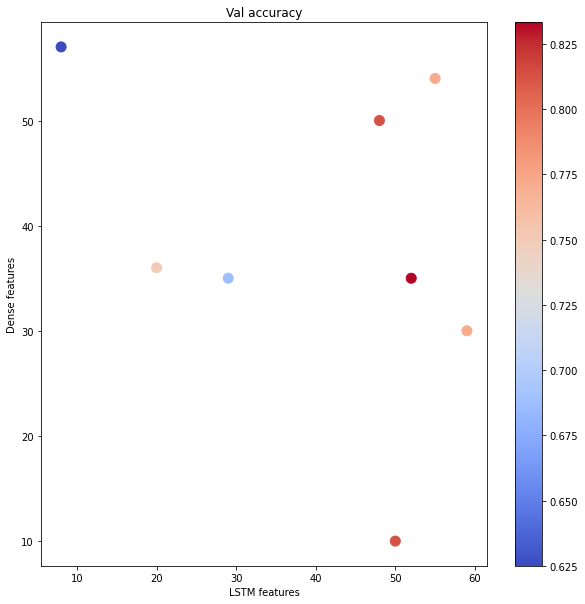

In [13]:
plt.figure(figsize=(10, 10))
x_scatter = [x[0] for x in results]
y_scatter = [x[1] for x in results]

marker_size = 100
colors = [results[x] for x in results]
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('LSTM features')
plt.ylabel('Dense features')
plt.title('Val accuracy')

In [14]:
best = list(sorted(results.items(), key=lambda item: item[1]))[-1][0]

In [15]:
model = build_model(*best)

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=4, epochs=64)

Epoch 1/64
50/50 [==============================] - 2s 13ms/step - loss: 4.9597 - accuracy: 0.4750 - val_loss: 3.9444 - val_accuracy: 0.5000
Epoch 2/64
50/50 [==============================] - 0s 9ms/step - loss: 3.1832 - accuracy: 0.5800 - val_loss: 2.5162 - val_accuracy: 0.6042
Epoch 3/64
50/50 [==============================] - 0s 9ms/step - loss: 2.0962 - accuracy: 0.6600 - val_loss: 1.7961 - val_accuracy: 0.6458
Epoch 4/64
50/50 [==============================] - 0s 10ms/step - loss: 1.5924 - accuracy: 0.6500 - val_loss: 1.3533 - val_accuracy: 0.6458
Epoch 5/64
50/50 [==============================] - 0s 10ms/step - loss: 1.3448 - accuracy: 0.6600 - val_loss: 1.1086 - val_accuracy: 0.6875
Epoch 6/64
50/50 [==============================] - 0s 9ms/step - loss: 1.0054 - accuracy: 0.7350 - val_loss: 1.1095 - val_accuracy: 0.6458
Epoch 7/64
50/50 [==============================] - 0s 10ms/step - loss: 0.8523 - accuracy: 0.7300 - val_loss: 0.7848 - val_accuracy: 0.7083
Epoch 8/64
50/50

Epoch 59/64
50/50 [==============================] - 0s 10ms/step - loss: 0.2499 - accuracy: 0.9550 - val_loss: 0.3649 - val_accuracy: 0.9375
Epoch 60/64
50/50 [==============================] - 0s 10ms/step - loss: 0.2016 - accuracy: 0.9600 - val_loss: 0.2731 - val_accuracy: 0.9167
Epoch 61/64
50/50 [==============================] - 0s 10ms/step - loss: 0.1508 - accuracy: 0.9900 - val_loss: 0.4002 - val_accuracy: 0.8750
Epoch 62/64
50/50 [==============================] - 0s 10ms/step - loss: 0.1455 - accuracy: 0.9950 - val_loss: 0.3206 - val_accuracy: 0.8958
Epoch 63/64
50/50 [==============================] - 0s 10ms/step - loss: 0.1450 - accuracy: 0.9900 - val_loss: 0.3415 - val_accuracy: 0.9167
Epoch 64/64
50/50 [==============================] - 0s 9ms/step - loss: 0.2233 - accuracy: 0.9550 - val_loss: 0.3226 - val_accuracy: 0.8958


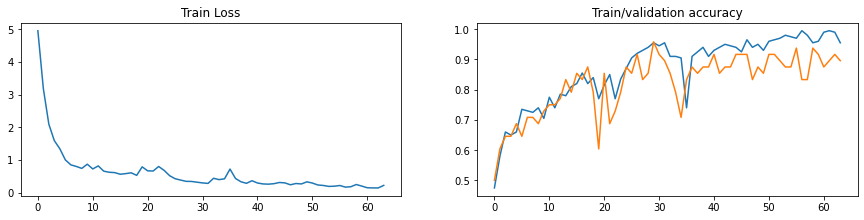

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])